In [1]:
import tensorflow 
import keras

Using TensorFlow backend.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [4]:
train_df = pd.read_csv("dataset/train.csv")
test_df = pd.read_csv("dataset/test.csv")

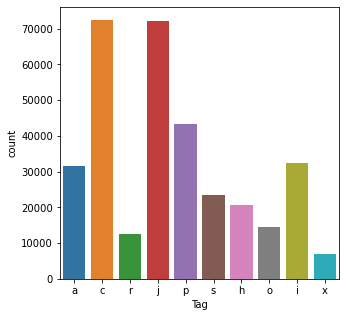

In [6]:
plt.figure(figsize=(5,5))
sns.countplot(train_df['Tag'])

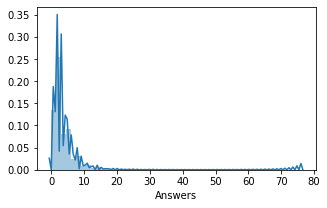

In [22]:
plt.figure(figsize=(5,3))
sns.distplot(train_df['Answers'])

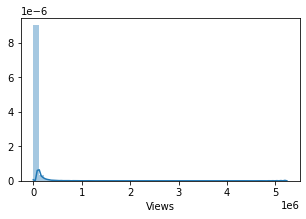

In [21]:
plt.figure(figsize=(5,3))
sns.distplot(train_df['Views'])

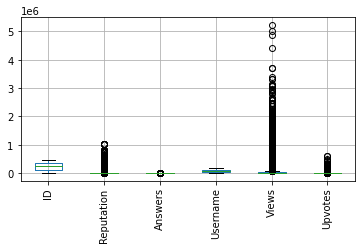

In [19]:
train_df.boxplot(rot=90,figsize=(6,3))

In [14]:
q1 = train_df.quantile(0.25)
q3 = train_df.quantile(0.75)

iqr = q3-q1

In [15]:
train_new = train_df[~((train_df>q3+1.5*iqr)|(train_df<q1-iqr*1.5)).any(axis=1)]

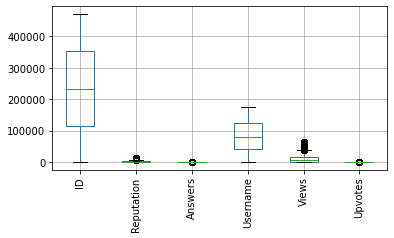

In [18]:
train_new.boxplot(rot=90,figsize=(6,3))

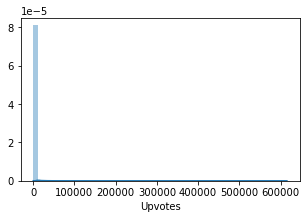

In [20]:
plt.figure(figsize=(5,3))
sns.distplot(train_df['Upvotes'])

In [52]:
x = train_new.drop(columns=["ID","Username","Upvotes"])
y = train_new.Upvotes.values
x.head()

,Tag,Reputation,Answers,Views
0,a,3942.0,2.0,7855.0
2,c,1358.0,4.0,8067.0
3,a,264.0,3.0,27064.0
4,c,4271.0,4.0,13986.0
5,r,440.0,1.0,5577.0


In [53]:
x_val = test_df.drop(columns=['ID','Username'])

In [66]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,RobustScaler,MinMaxScaler,StandardScaler

In [55]:
le = LabelEncoder()
x['Tag'] = le.fit_transform(x['Tag'])

transformer = make_column_transformer((RobustScaler(),['Reputation','Views']),
                                     (MinMaxScaler(),['Answers']),
                                     (OneHotEncoder(handle_unknown='ignore'),['Tag']))

In [56]:
x = transformer.fit_transform(x)

In [57]:
x_val['Tag'] = le.transform(x_val['Tag'])
x_val = transformer.transform(x_val)

In [67]:
sc = StandardScaler()
y = sc.fit_transform(y.reshape(-1,1))

In [59]:
print(le.classes_)
print(le.transform(le.classes_))

['a' 'c' 'h' 'i' 'j' 'o' 'p' 'r' 's' 'x']
[0 1 2 3 4 5 6 7 8 9]


In [60]:
import joblib

In [61]:
filename = "column_trans.sav"
joblib.dump(transformer,filename)

['column_trans.sav']

In [63]:
from sklearn.model_selection import train_test_split

In [68]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [73]:
print(x_train.shape)

(194850, 13)


In [69]:
#from sklearn.neighbors import KNeighborsClassifier

In [72]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization
from keras.callbacks import ModelCheckpoint,EarlyStopping
from livelossplot import PlotLossesKeras

In [74]:
def create_model():
    model = Sequential()
    
    model.add(Dense(256,activation='relu',input_shape=(x_train.shape[1],)))
    model.add(Dropout(0.4))
    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.4))
    model.add(BatchNormalization())
    model.add(Dense(16,activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1,activation='linear'))
    
    return model

model = create_model()
model.compile(loss='mse',optimizer='adam',metrics=['mae'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               3584      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                1040      
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)               

In [76]:
callback = [ModelCheckpoint('tmp_weights/eopchs__{epoch:02d}',
                           save_best_only=True,
                           save_weights_only=True,
                           monitor='val_loss'),
           EarlyStopping(patience=5,
                        monitor='val_loss'),
           PlotLossesKeras()]

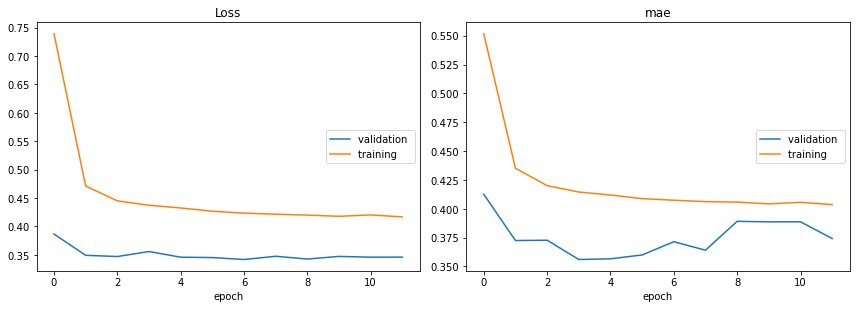

Loss
	validation       	 (min:    0.342, max:    0.387, cur:    0.346)
	training         	 (min:    0.417, max:    0.739, cur:    0.417)
mae
	validation       	 (min:    0.356, max:    0.413, cur:    0.374)
	training         	 (min:    0.404, max:    0.552, cur:    0.404)


In [77]:
h = model.fit(x_train,y_train,
             validation_data=(x_test,y_test),
             epochs=50,
             batch_size=256,
             callbacks=callback)

In [82]:
y_pred = model.predict(x_val)
y_pred = sc.inverse_transform(y_pred)
y_pred = np.squeeze(y_pred)

In [83]:
sub = pd.DataFrame({"ID":test_df.ID,'Upvotes':y_pred})

In [85]:
sub.to_csv('Submissions.csv',index=False)

In [86]:
model.save("Models/final_model.h5")

model_json = model.to_json()

with open('Models/final_model.json','w') as file:
    file.write(model_json)